Goal: Create a hierarchical clustering built upon both genotypic and phenotypic information. 

One proposal (40 total features): 
- 20 features for normalized abundance at T0 across native pHs
- 11 features for normalized abundance at T9 across perturbed pHs
- 9 features for structural and sequence-based information:
  - (3) Alpha helix, Beta sheet, Coil proportions
  - (2) Solvent-Accessible surface area (both total and average per residue)
  - (1) Radius of Gyration (compactness)
  - (1) Length
  - (1) Instability Index
  - (1) Isoelectric Point (pI) — pH at which the protein is net neutral




First, I need the ORFs for each of the 60 for which we have a compelete sequence after the first clustering. Then, I will use a cluster map to reduce redudancy, gather the relevant data for each one. 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mgsa.helpers import plot
from mgsa.io import get_data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Start over, no conditioning out, but using the incomplete to complete map

In [131]:
KO = 'K00370'
map = '09'


complete_ids = pd.read_csv(f'../out/aaseqs/{KO}/long_complete_orf_ids.txt', header = None)
complete_ids = complete_ids.values

all_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', sep = '\t', header=None)

map = pd.read_csv(f'../out/aaseqs/{KO}/incomplete_to_complete_seq_mapping.tsv', sep = '\t')
map = map.values

T0data = np.zeros((len(complete_ids), 20))
T9data = np.zeros((len(complete_ids), 10, 11))

for i, id in enumerate(complete_ids):
    got_data = get_data(id)
    T0data[i] += got_data[0]
    T9data[i] += got_data[1]

print(T9data[:,:,1].shape)

for i, id in enumerate(map[:,0]):
    complete_id = map[i, 1]
    idx = np.where(complete_ids == complete_id)[0][0]
    got_data = get_data(id)
    T0data[idx] += got_data[0]
    T9data[idx] += got_data[1]






(57, 10)


In [134]:

from sklearn.preprocessing import MinMaxScaler

strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
strc_data = strc_data.values
strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
strc_data = scaler.fit_transform(strc_data)



T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

data = T0data 
for i in range(10):
    T9temp = T9data[:,i,:]
    T9temp = T9temp / T9temp.sum(axis = 1, keepdims=True)
    T9temp = np.nan_to_num(T9temp, nan = 0)
    data = np.hstack((data, T9temp))
    
data = np.hstack((data, strc_data))



# weights = np.concatenate([
#     np.full(20, 1/np.sqrt(20)),    
#     np.full(110, 1/np.sqrt(110)),  
#     np.full(8, 1/np.sqrt(8))       
# ])


weights = np.concatenate([
    np.full(20, 0.5),    
    np.full(110, 0.5),  
    np.full(8, 0)       
])

weighted_data = data * weights 



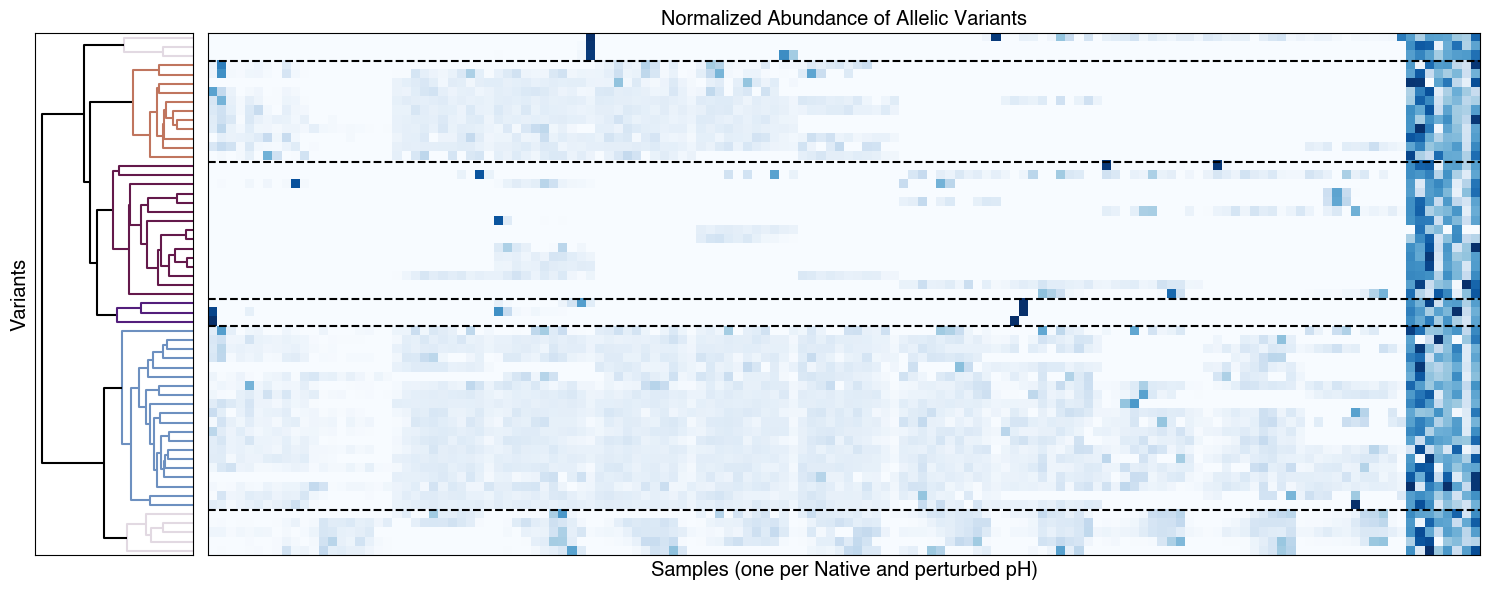

In [138]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex


Z = linkage(weighted_data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 6
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

#cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]
cmap = plt.cm.twilight  # Or any other colormap (e.g., 'viridis', 'plasma')
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

im = ax2.imshow(data[leaf_indices], aspect='auto', cmap='Blues',
                interpolation='nearest', origin='lower', vmin = 0, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.set_xticks([])

ax2.set_title('Normalized Abundance of Allelic Variants', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('Samples (one per Native and perturbed pH)', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

    
plt.show()

[ 4 24 27 42 53]


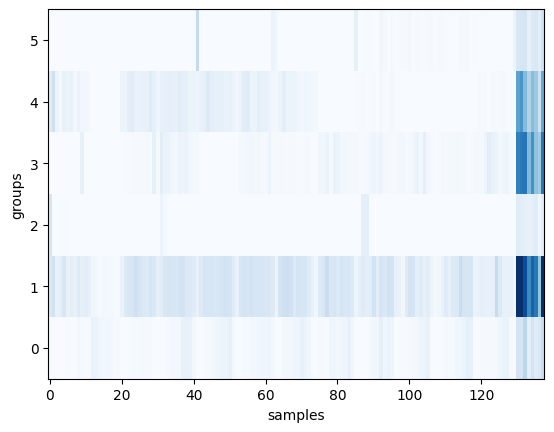

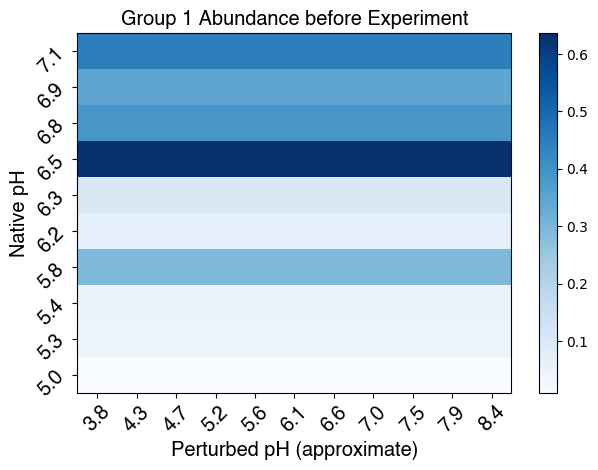

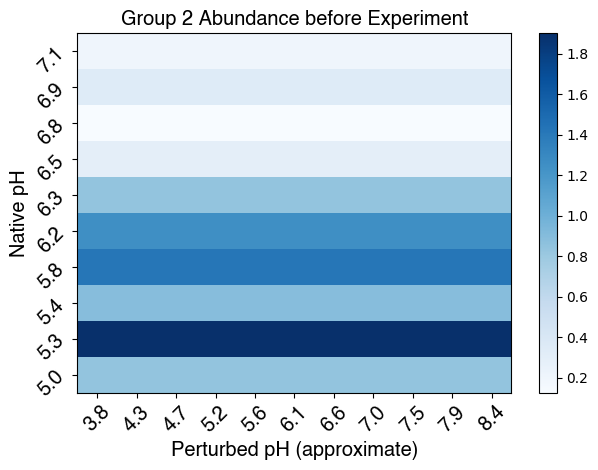

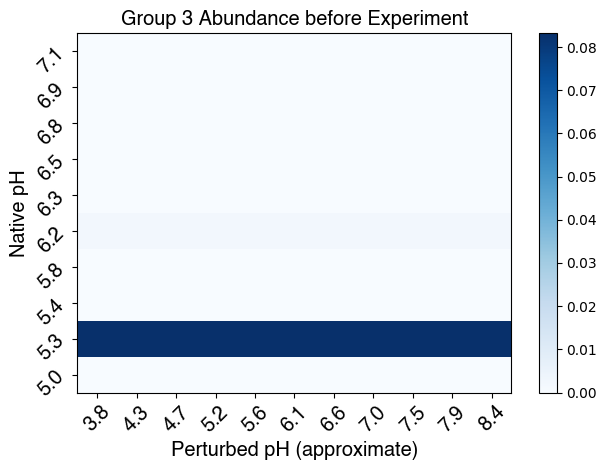

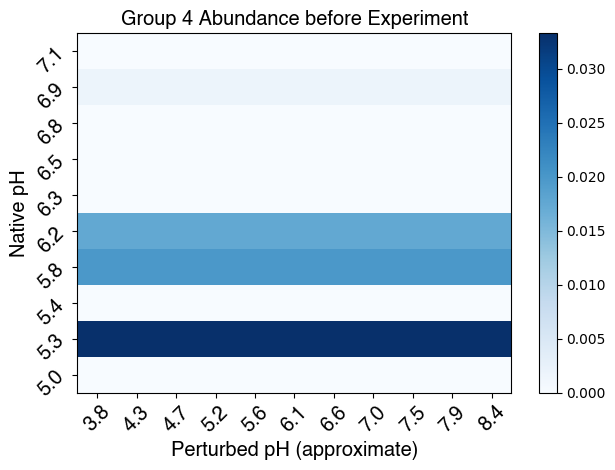

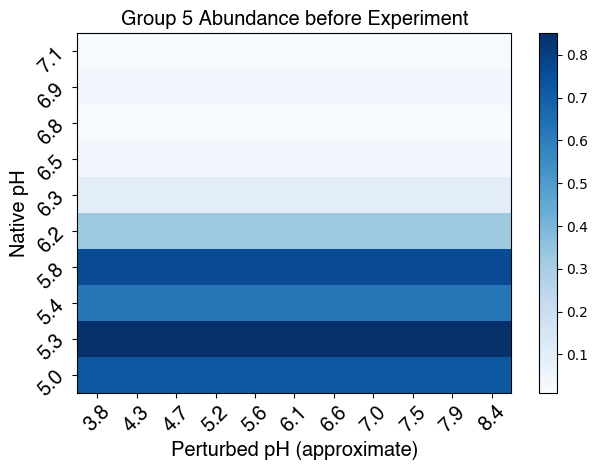

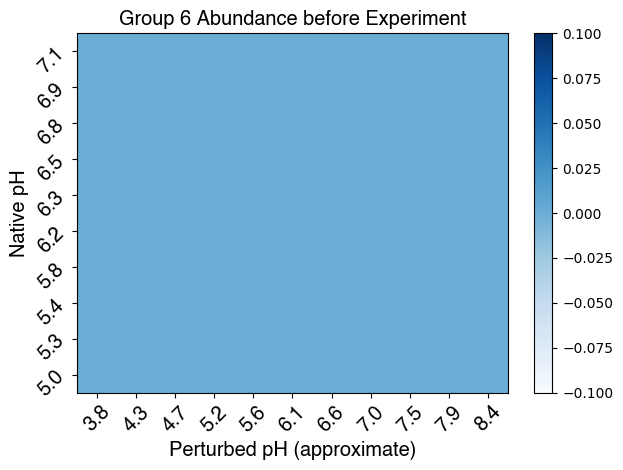

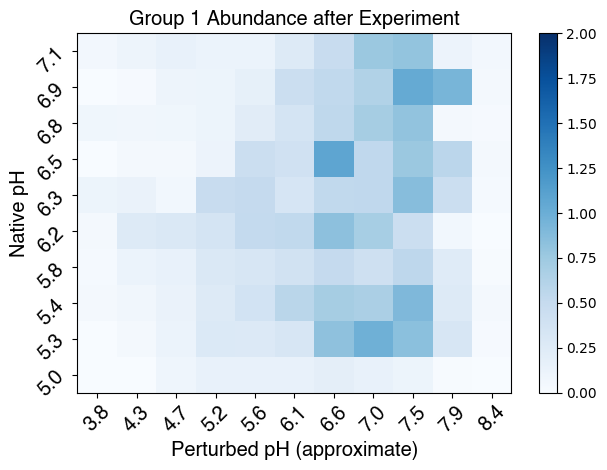

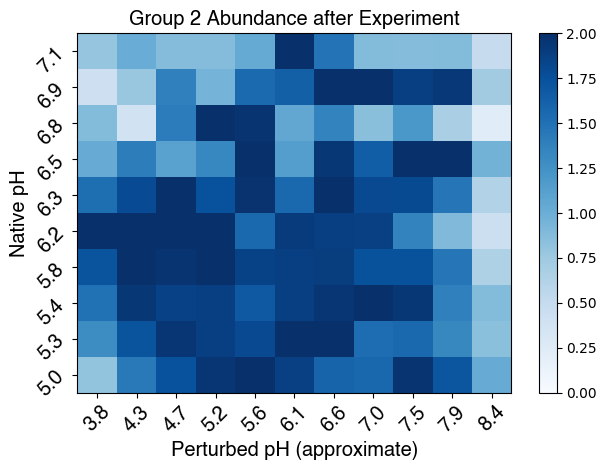

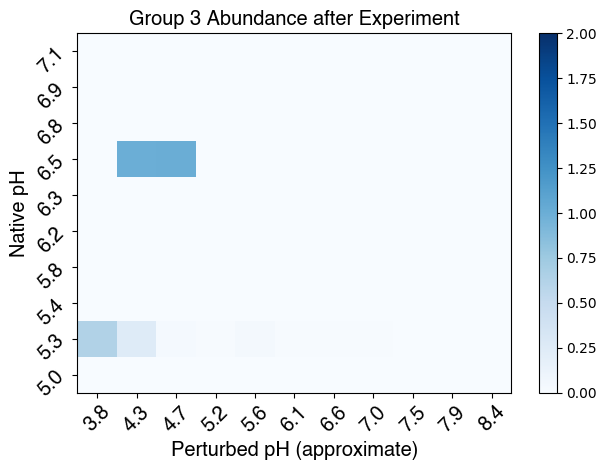

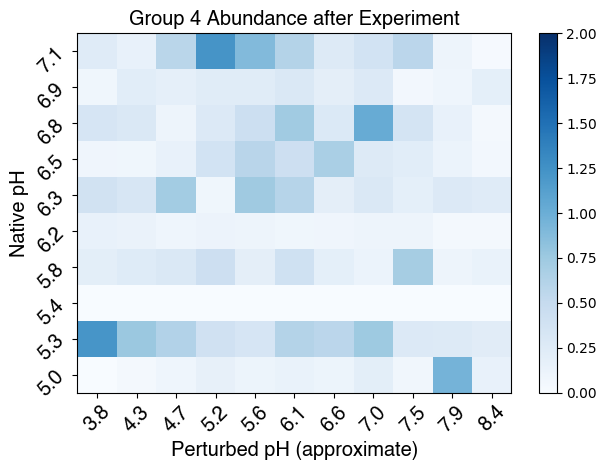

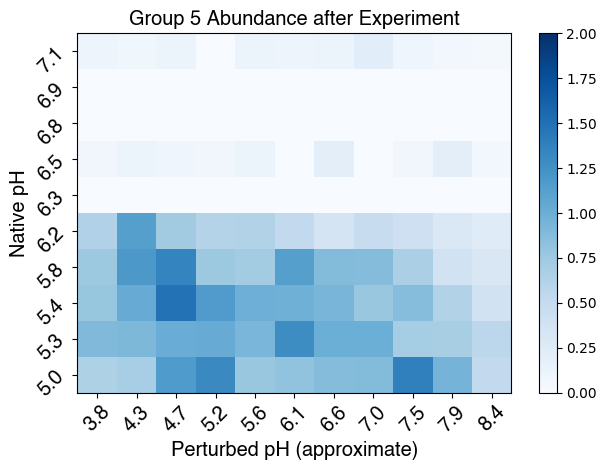

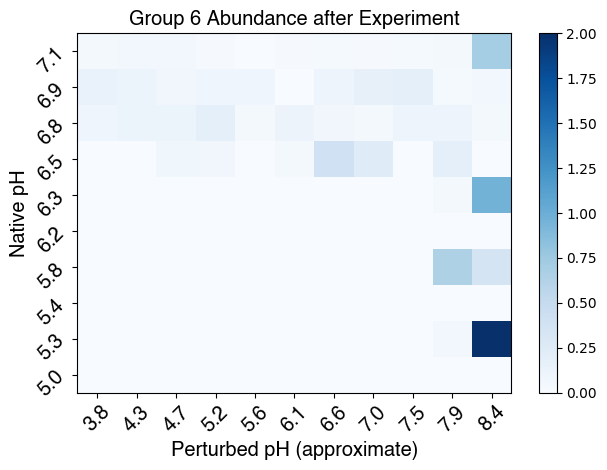

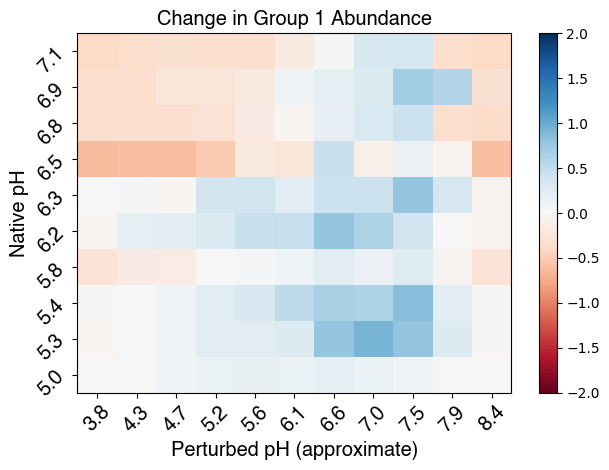

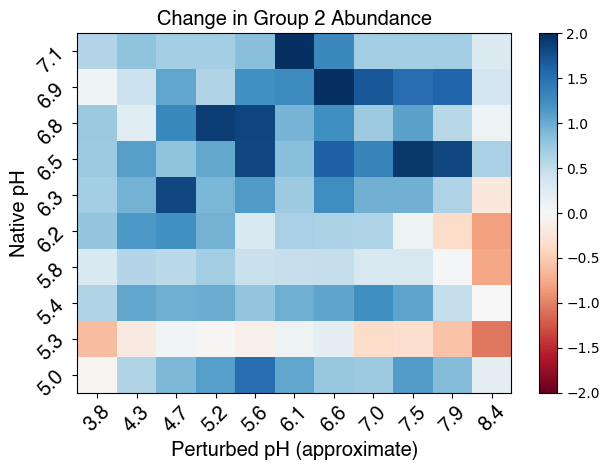

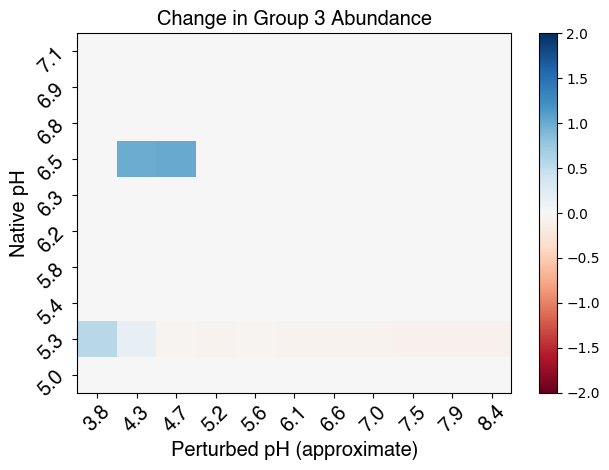

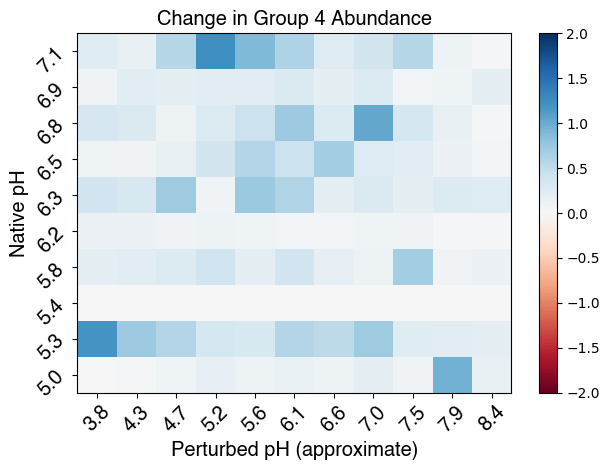

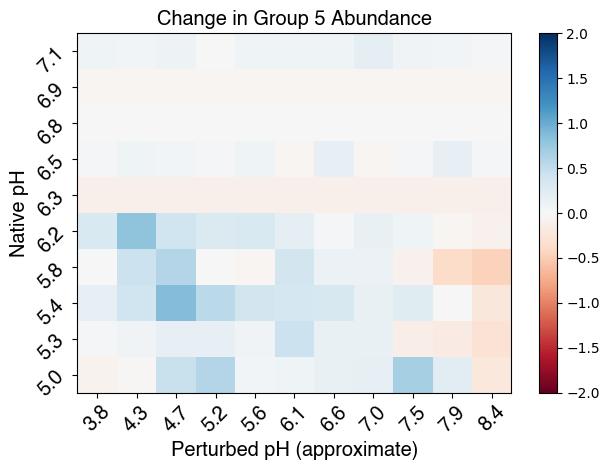

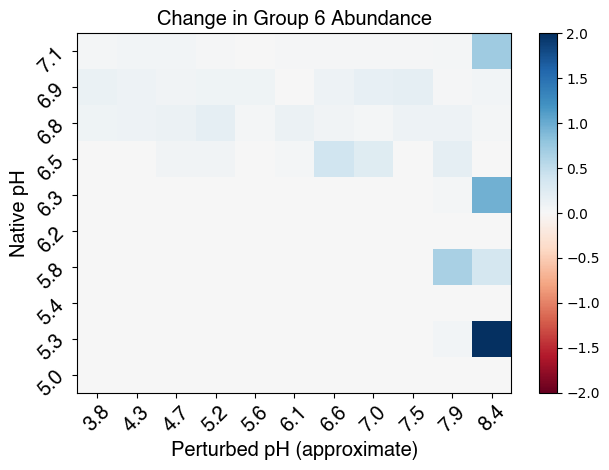

In [ ]:

new_data = data[leaf_indices]

print(boundaries)

#redo this but with the absolute data 
groups = np.zeros((n_clusters,138))

for i, datum in enumerate(new_data):
    for j in range(1, n_clusters-1):
        if i > boundaries[j - 1] and i < boundaries[j]:
            groups[j] += datum
    if i < boundaries[0]:
        groups[0] += datum
    elif i > boundaries[n_clusters-2]:
        groups[n_clusters-1] += datum

        
plt.show()
plt.imshow(groups, cmap = 'Blues', origin = 'lower', aspect = 'auto')
plt.xlabel('samples')
plt.ylabel('groups')
plt.show()



selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]

#T0
groups_T0 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(n_clusters):
        groups_T0[j][i] = groups[j][selected][i]
        
for j in range(n_clusters):
    plot(groups_T0[j], f'Group {j+1} Abundance before Experiment')

#T9
groups_T9 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(11): #perturbed pH
        for k in range(n_clusters):
            groups_T9[k][i][j] = groups[k][20 + 11*i + j]
            
for i in range(n_clusters):
    plot(groups_T9[i],  f'Group {i+1} Abundance after Experiment', vmin = 0, vmax = 2)
        
for i in range(n_clusters):
    plot(groups_T9[i] - groups_T0[i], f'Change in Group {i+1} Abundance', vmin = -2, vmax = 2, cmap = 'RdBu')


#change



Idea 2: Condition out perturbed pH in the same way you did above for native pH. Then Native pH will have 10 features, predicted from T9 data. Essentially, we are "predicting" the T0 data using the T9 data. 

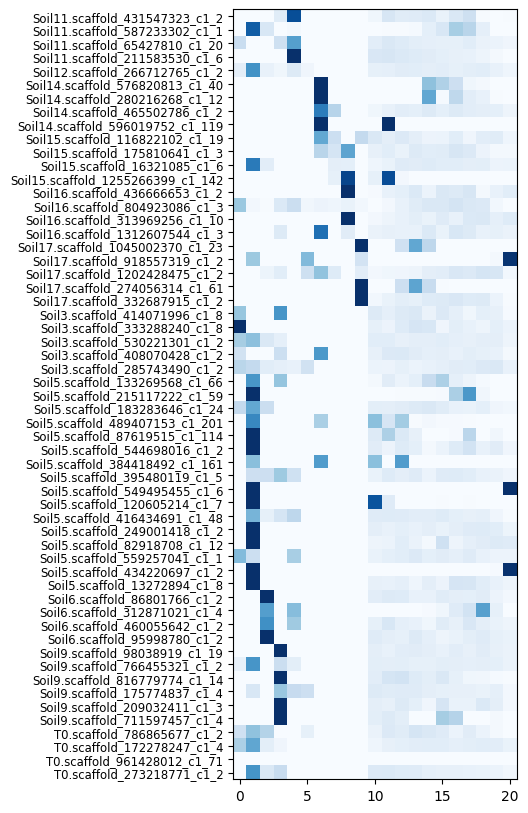

'\nfor id in complete_seq_ids:\n    data = get_data(id)\n    print(data[0])\n    plot(data[1], id)\n'

In [26]:

drug = 'None'
map = '09'
KO = 'K00370'

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

cluster_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', header=None)
cluster_ids = cluster_ids.values


T0data = np.zeros((len(cluster_ids), 10))



T9data = np.zeros((len(cluster_ids), 11))
#Add all of the T9 data arrays together to condition out native environment
for i, soil in enumerate(soils):
    filename = f"../out/{KO}abundances/{soil}data_{map}_{drug}_{KO}.tsv"  
    df = pd.read_csv(filename, sep='\t', header = None)
    df = df.values
    
    row_sum = df.sum(axis=1).reshape(-1, 1)
    row_sum = [entry[0] for entry in row_sum]
    T0data[:, i] += row_sum
    
    T9data += df

T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

T9data = T9data / T9data.sum(axis = 1, keepdims=True)
T9data = np.nan_to_num(T9data, nan = 0)
    

data = np.hstack((T0data, T9data))
#plt.figure(figsize=(10,10))
#plt.imshow(data, cmap = 'Blues', vmax = 1)

'''
for i in range(len(cluster_ids)):
    print(i, 'id:', cluster_ids[i][0], 'data: ', data[i])
    
'''

#load in round_1 ids which have complete sequences 

KO = 'K00370'

complete_seq_ids = pd.read_csv('../out/aaseqs/long_complete_orf_ids.txt', header = None)
complete_seq_ids = complete_seq_ids.values
complete_seq_ids = [item[0] for item in complete_seq_ids]
cluster_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', header=None)
cluster_ids = cluster_ids.values
cluster_ids = [item[0] for item in cluster_ids]


indices = [cluster_ids.index(item) for item in complete_seq_ids if item in cluster_ids]

data_subset = []

for idx in indices:
    data_subset.append(data[idx])
    
data_subset = [item.tolist() for item in data_subset]



fig, ax = plt.subplots(figsize=(5,10))  
im = ax.imshow(data_subset, cmap = 'Blues')
ax.set_yticks(np.arange(len(complete_seq_ids)))
_ = ax.set_yticklabels(complete_seq_ids, fontsize='small')
plt.show()

'''
for id in complete_seq_ids:
    data = get_data(id)
    print(data[0])
    plot(data[1], id)
'''

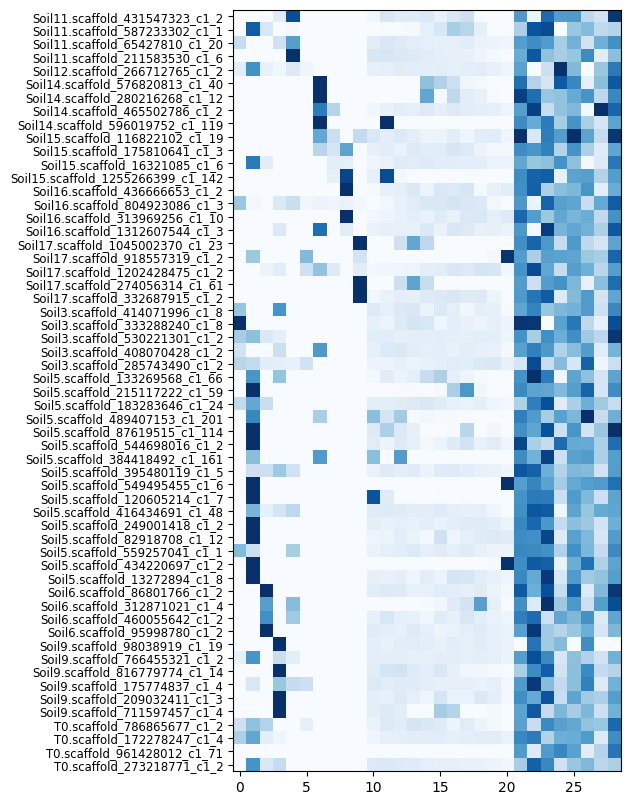

In [49]:
from sklearn.preprocessing import MinMaxScaler

strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
strc_data = strc_data.values
strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
strc_data = scaler.fit_transform(strc_data)

data = np.hstack((data_subset, strc_data))


fig, ax = plt.subplots(figsize=(5,10))  
im = ax.imshow(data, cmap = 'Blues', vmin = 0, vmax = 1)
ax.set_yticks(np.arange(len(complete_seq_ids)))
_ = ax.set_yticklabels(complete_seq_ids, fontsize='small')
plt.show()




Now, make clusters with a dendogram

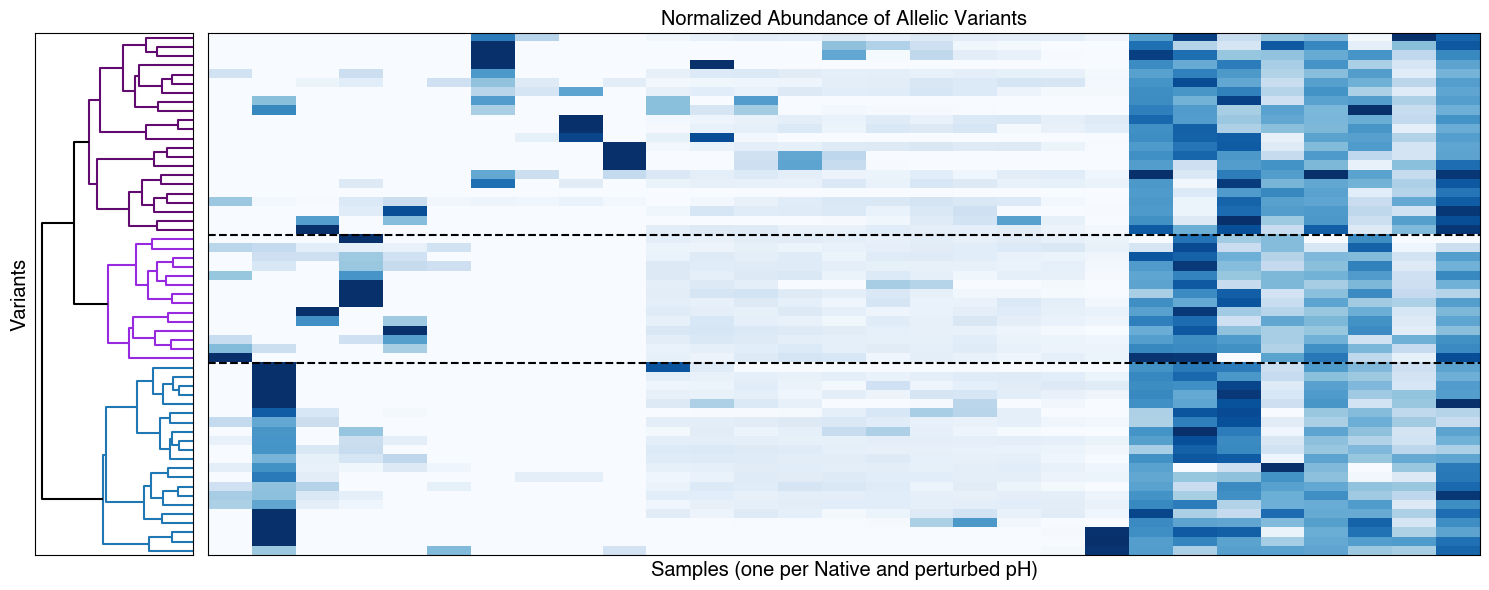

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist

Z = linkage(data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 3
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]


def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

im = ax2.imshow(data[leaf_indices], aspect='auto', cmap='Blues',
                interpolation='nearest', origin='lower', vmin = 0, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.set_xticks([])

ax2.set_title('Normalized Abundance of Allelic Variants', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('Samples (one per Native and perturbed pH)', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

    
plt.show()

Below, function for secondary structure classification

In [ ]:
from Bio.PDB import PDBParser, PPBuilder
from collections import defaultdict
import math

def classify_secondary_structure(phi, psi):
    """Classify residue as helix, sheet, or coil based on dihedral angles"""
    if phi is None or psi is None:
        return 'coil'
    
    phi_deg = math.degrees(phi)
    psi_deg = math.degrees(psi)
    
    # Alpha-helix range (-57,-47)
    if (-90 < phi_deg < -30) and (-77 < psi_deg < -17):
        return 'helix'
    # Beta-sheet range (-119,113)
    elif (-180 < phi_deg < -40) and (90 < psi_deg < 180) or (-180 < phi_deg < -40) and (-180 < psi_deg < -100):
        return 'sheet'
    else:
        return 'coil'

def get_secondary_structure_proportions(pdb_file):
    """Calculate secondary structure proportions using dihedral angles"""
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    ppb = PPBuilder()
    
    secondary_structure = defaultdict(int)
    total_residues = 0
    
    for pp in ppb.build_peptides(structure):
        # Get phi/psi angles for each residue
        angles = pp.get_phi_psi_list()
        for i, residue in enumerate(pp):
            total_residues += 1
            phi, psi = angles[i]
            ss_type = classify_secondary_structure(phi, psi)
            secondary_structure[ss_type] += 1
    
    if total_residues > 0:
        return {
            'helix': secondary_structure['helix'] / total_residues,
            'sheet': secondary_structure['sheet'] / total_residues,
            'coil': secondary_structure['coil'] / total_residues
        }
    return {'helix': 0, 'sheet': 0, 'coil': 0}


pdb_file = '../out/structure/nar/Soil9.scaffold_209032411_c1_3.pdb'
proportions = get_secondary_structure_proportions(pdb_file)
print(f"Helix: {proportions['helix']:.2%}")
print(f"Sheet: {proportions['sheet']:.2%}")
print(f"Coil: {proportions['coil']:.2%}")

coil_data = []

for id in complete_seq_ids:
    pdb_file = f'../out/structure/nap/{id}.pdb'
    proportions = get_secondary_structure_proportions(pdb_file)
    coil_data.append([id, proportions['helix'], proportions['sheet'], proportions['coil']])
    print([id, proportions['helix'], proportions['sheet'], proportions['coil']])
    


Helix: 35.46%
Sheet: 41.61%
Coil: 22.93%
['Soil11.scaffold_431547323_c1_2', 0.3541147132169576, 0.42144638403990026, 0.22443890274314215]
['Soil11.scaffold_587233302_c1_1', 0.3497975708502024, 0.4145748987854251, 0.23562753036437248]
['Soil11.scaffold_65427810_c1_20', 0.35390946502057613, 0.41069958847736626, 0.2353909465020576]
['Soil11.scaffold_211583530_c1_6', 0.3383280757097792, 0.4187697160883281, 0.24290220820189273]
['Soil12.scaffold_266712765_c1_2', 0.337087691069992, 0.40627514078841515, 0.25663716814159293]
['Soil14.scaffold_576820813_c1_40', 0.35571542765787373, 0.40687450039968026, 0.23741007194244604]
['Soil14.scaffold_280216268_c1_12', 0.3431528662420382, 0.4052547770700637, 0.2515923566878981]
['Soil14.scaffold_465502786_c1_2', 0.35218093699515346, 0.41033925686591277, 0.23747980613893377]
['Soil14.scaffold_596019752_c1_119', 0.3471882640586797, 0.4172779136104319, 0.23553382233088835]
['Soil15.scaffold_116822102_c1_19', 0.33990536277602523, 0.41719242902208203, 0.242902

In [58]:

column = [row[2] for row in coil_data]
print(np.mean(column))
print(np.std(column))


0.41462075579218993
0.005389658967763842
